# 可转债    多因子打分模型

### 因子来源：数立方提取 + 民生研报23/08/02--可转债股债性 + 东方研报23/07/01--可转债多因子模型初探

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import dcube as dc
import matplotlib.pyplot as plt
pro = dc.pro_api('bffee2be40ae0f76164999bd14b0dd02a4f47c3175de036c9c21c864')
from itertools import combinations
%run Quant_useful_packages_ccb.ipynb

df_con_value = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__conv_value.csv',index_col=0)
df_strb_value = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__strbvalue.csv',index_col=0)
df_ccb_pctchg = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__pctchange.csv',index_col=0)
df_stock_close = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_CLOSE.csv',index_col=0)
df_BS_option_price_per_stock = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__BS_price.csv',index_col=0)
df_ccb_conv_ratio = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__conv_ratio.csv',index_col=0)
df_ccb_strb_price = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__strbvalue.csv',index_col=0)
df_ccb_close = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__close.csv',index_col=0)
df_stock_pctchg = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_PCTCHANGE.csv',index_col=0)
df_stock_high = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_HIGH.csv',index_col=0)
df_stock_low = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODP__S_DQ_LOW.csv',index_col=0)
df_ccb_high = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__high.csv',index_col=0)
df_ccb_low = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__low.csv',index_col=0)
df_ccb_convpremium_ratio = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__convpremium_ratio.csv',index_col=0)
df_stock_mv = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__EODDI__S_VAL_MV.csv',index_col=0)
df_stock_roe = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__s_qfa_roe_deducted_diff4q_8qzscore.csv',index_col=0)
df_stock_corr = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__PCTcorrQZ_20d.csv',index_col=0)
df_stock_beta = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__betaQADQ_20d.csv',index_col=0)
df_BS_iv = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__BS_iv.csv',index_col=0)
df_BS_iv_bias = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__BS_iv_bias.csv',index_col=0)
df_ccb_outstanding_balance = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__outstanding_balance.csv',index_col=0)
df_ccb_turn = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__TR20DDIVTR60D.csv',index_col=0)
df_ccb_amount = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__amount.csv',index_col=0)
df_stock_dl1 = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__dp_df52cs_p5dNBr-18-23.csv',index_col=0)
df_stock_dl2 = pd.read_csv(r'C:\Users\nibh\Desktop\FZ\CCB\CCB__S__dp_df62l2pv9cs_p5dNBr-18-23.csv',index_col=0)


### 根据平底溢价率划分偏股、平衡、偏债型转债

In [3]:
df_par_value = df_con_value/df_strb_value - 1
df_ccb_class = df_par_value.copy()
for code in df_con_value.columns:   # 1偏股，2平衡，3偏债
    df_ccb_class[code] = np.where(df_ccb_class[code]>0.2, 1,
                                  np.where(df_ccb_class[code]>=-0.2, 2,
                                          np.where(df_ccb_class[code]<-0.2, 3, df_ccb_class[code])))
# df_ccb_class

In [4]:
# 每天每组转债个数
a=df_ccb_class.replace(np.nan,0)
for i in df_ccb_class.index:
    print(i,sum(a.loc[i,:]==1),sum(a.loc[i,:]==2),sum(a.loc[i,:]==3))

2016-01-04 2 13 12
2016-01-05 2 13 13
2016-01-06 2 14 12
2016-01-07 1 13 14
2016-01-08 1 13 14
2016-01-11 1 10 17
2016-01-12 1 11 16
2016-01-13 1 9 18
2016-01-14 1 10 17
2016-01-15 1 8 21
2016-01-18 1 7 22
2016-01-19 1 8 21
2016-01-20 1 7 22
2016-01-21 1 7 22
2016-01-22 1 10 21
2016-01-25 1 10 21
2016-01-26 1 9 22
2016-01-27 1 7 24
2016-01-28 1 5 26
2016-01-29 1 6 25
2016-02-01 1 5 26
2016-02-02 1 6 26
2016-02-03 1 7 25
2016-02-04 1 8 24
2016-02-05 1 8 24
2016-02-15 1 7 25
2016-02-16 1 8 24
2016-02-17 1 9 23
2016-02-18 1 9 23
2016-02-19 1 8 24
2016-02-22 1 11 21
2016-02-23 1 11 21
2016-02-24 1 11 21
2016-02-25 0 8 25
2016-02-26 0 11 24
2016-02-29 0 9 26
2016-03-01 0 11 24
2016-03-02 0 14 22
2016-03-03 0 14 22
2016-03-04 0 11 25
2016-03-07 0 12 24
2016-03-08 0 12 24
2016-03-09 0 13 23
2016-03-10 0 11 25
2016-03-11 0 13 23
2016-03-14 0 15 22
2016-03-15 0 14 23
2016-03-16 0 14 23
2016-03-17 0 14 23
2016-03-18 1 18 19
2016-03-21 1 18 19
2016-03-22 1 18 19
2016-03-23 1 18 19
2016-03-24 1 17

2017-11-13 33 54 81
2017-11-14 29 58 81
2017-11-15 26 59 83
2017-11-16 29 53 86
2017-11-17 27 54 88
2017-11-20 30 54 85
2017-11-21 30 52 87
2017-11-22 30 52 87
2017-11-23 25 54 90
2017-11-24 26 58 87
2017-11-27 22 59 89
2017-11-28 27 58 87
2017-11-29 26 62 85
2017-11-30 25 60 88
2017-12-01 28 61 85
2017-12-04 27 61 87
2017-12-05 26 58 92
2017-12-06 28 60 92
2017-12-07 24 65 93
2017-12-08 24 67 92
2017-12-11 25 66 91
2017-12-12 25 66 91
2017-12-13 26 67 91
2017-12-14 26 66 92
2017-12-15 27 65 94
2017-12-18 27 66 94
2017-12-19 29 65 94
2017-12-20 27 65 98
2017-12-21 30 65 96
2017-12-22 34 62 98
2017-12-25 34 61 100
2017-12-26 37 58 100
2017-12-27 34 64 100
2017-12-28 37 65 96
2017-12-29 39 67 93
2018-01-02 43 65 91
2018-01-03 47 61 91
2018-01-04 47 61 91
2018-01-05 46 63 90
2018-01-08 46 64 89
2018-01-09 44 66 89
2018-01-10 41 68 90
2018-01-11 46 61 92
2018-01-12 42 66 91
2018-01-15 36 64 99
2018-01-16 36 63 101
2018-01-17 37 66 98
2018-01-18 39 66 96
2018-01-19 42 66 94
2018-01-22 44 64

2019-09-17 61 133 130
2019-09-18 64 130 130
2019-09-19 63 136 124
2019-09-20 65 136 123
2019-09-23 62 136 127
2019-09-24 62 135 129
2019-09-25 57 134 134
2019-09-26 53 134 138
2019-09-27 56 125 142
2019-09-30 51 130 140
2019-10-08 51 132 138
2019-10-09 54 133 134
2019-10-10 56 131 135
2019-10-11 56 133 134
2019-10-14 61 134 129
2019-10-15 60 130 133
2019-10-16 59 132 132
2019-10-17 56 138 129
2019-10-18 52 139 133
2019-10-21 52 142 132
2019-10-22 54 141 131
2019-10-23 56 137 134
2019-10-24 53 142 133
2019-10-25 55 140 132
2019-10-28 63 139 128
2019-10-29 58 141 132
2019-10-30 51 144 135
2019-10-31 52 142 137
2019-11-01 56 142 134
2019-11-04 57 145 131
2019-11-05 59 143 131
2019-11-06 56 144 133
2019-11-07 57 142 134
2019-11-08 57 142 134
2019-11-11 55 142 137
2019-11-12 53 142 139
2019-11-13 52 142 140
2019-11-14 53 144 138
2019-11-15 51 145 140
2019-11-18 54 146 138
2019-11-19 56 144 137
2019-11-20 54 146 137
2019-11-21 51 147 138
2019-11-22 46 151 138
2019-11-25 44 152 139
2019-11-26

2021-08-11 174 204 121
2021-08-12 181 197 122
2021-08-13 182 198 121
2021-08-16 182 201 120
2021-08-17 171 199 133
2021-08-18 170 202 130
2021-08-19 168 201 133
2021-08-20 164 203 134
2021-08-23 177 201 124
2021-08-24 180 199 122
2021-08-25 178 204 118
2021-08-26 174 208 118
2021-08-27 174 208 118
2021-08-30 180 200 121
2021-08-31 180 202 117
2021-09-01 175 201 120
2021-09-02 181 198 117
2021-09-03 179 205 111
2021-09-06 189 201 106
2021-09-07 193 197 104
2021-09-08 197 195 101
2021-09-09 200 189 103
2021-09-10 193 193 106
2021-09-13 196 196 99
2021-09-14 196 188 108
2021-09-15 195 187 109
2021-09-16 186 186 118
2021-09-17 184 185 119
2021-09-22 187 183 119
2021-09-23 191 184 114
2021-09-24 181 187 122
2021-09-27 162 196 130
2021-09-28 162 198 128
2021-09-29 147 205 136
2021-09-30 158 196 133
2021-10-08 168 196 123
2021-10-11 169 198 120
2021-10-12 159 203 125
2021-10-13 162 201 124
2021-10-14 160 202 125
2021-10-15 160 198 128
2021-10-18 166 195 125
2021-10-19 169 189 127
2021-10-20 1

2023-02-15 163 258 156
2023-02-16 151 263 163
2023-02-17 149 264 164
2023-02-20 153 267 157
2023-02-21 153 271 153
2023-02-22 152 273 153
2023-02-23 159 270 150
2023-02-24 150 277 152
2023-02-27 146 275 158
2023-02-28 148 276 155
2023-03-01 149 283 146
2023-03-02 148 276 155
2023-03-03 146 279 154
2023-03-06 146 281 153
2023-03-07 139 277 165
2023-03-08 137 282 163
2023-03-09 143 280 161
2023-03-10 135 278 171
2023-03-13 141 274 169
2023-03-14 141 267 176
2023-03-15 141 270 171
2023-03-16 128 273 183
2023-03-17 130 273 181
2023-03-20 129 273 182
2023-03-21 132 281 174
2023-03-22 139 278 172
2023-03-23 142 278 172
2023-03-24 139 280 172
2023-03-27 139 285 168
2023-03-28 131 289 172
2023-03-29 135 279 178
2023-03-30 131 282 178
2023-03-31 139 280 174
2023-04-03 140 284 169
2023-04-04 137 284 175
2023-04-06 140 285 172
2023-04-07 146 283 168
2023-04-10 134 291 173
2023-04-11 135 292 173
2023-04-12 139 294 166
2023-04-13 134 296 170
2023-04-14 136 299 166
2023-04-17 136 303 163
2023-04-18 

### 民生研报23/08/02因子计算

In [2]:
# 1.偏股型转债

# 转债收益率因子
factor_ret60 =df_ccb_pctchg.rolling(60,min_periods=30).mean()
# 正股波动率因子
factor_stock_std = df_stock_close.rolling(21,min_periods=10).std()
# BS定价偏差因子
df_BS_option_price = df_BS_option_price_per_stock * df_ccb_conv_ratio
df_BS_ccb_price = df_BS_option_price + df_ccb_strb_price
factor_deviation_BS = (df_BS_ccb_price - df_ccb_close) / df_ccb_close 


# 2.平衡型转债

# 正股收益率因子3
factor_stock_mean40 = df_stock_pctchg.rolling(40,min_periods=20).mean()
# 转债-正股振幅差2
df_stock_amplitude = (df_stock_high - df_stock_low) / df_stock_close.shift(1)
df_ccb_amplitude = (df_ccb_high - df_ccb_low) / df_ccb_close.shift(1)
df_dif_amplitude = df_stock_amplitude - df_ccb_amplitude
factor_dif_amplitude = df_dif_amplitude.rolling(20,min_periods=10).mean()


# 3.偏债型转债

# 双低因子
factor_dual_low = df_ccb_close + df_ccb_convpremium_ratio*100

In [3]:
factor_deviation_BS.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_deviation_BS.csv')
df_BS_ccb_price.to_csv(r'C:\Users\nibh\Desktop\FZ\CCB\factor_BS_price.csv')

### 多因子打分加总

In [ ]:
def factor_rank(list_df_factor):
    df_factor_rank = pd.DataFrame()
    for i,df_factor in enumerate(list_df_factor):
        df_factor_rank = df_factor_rank.add(df_factor.rank(pct=True,axis=1),fill_value=0)
    return df_factor_rank

factor_rank_class1 = factor_rank([factor_ret60,factor_stock_std,factor_deviation_BS])
factor_rank_class2 = factor_rank([factor_stock_mean40,factor_dif_amplitude,factor_deviation_BS])

### 民生研报结果

factor_name: factor_rank_class1
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.131202,-0.000009,-0.000193
group_02,0.226021,-0.000333,-0.000649
group_03,0.246166,-0.000035,-0.000380
group_04,0.224602,0.000026,-0.000288
group_05,0.105117,0.000351,0.000204


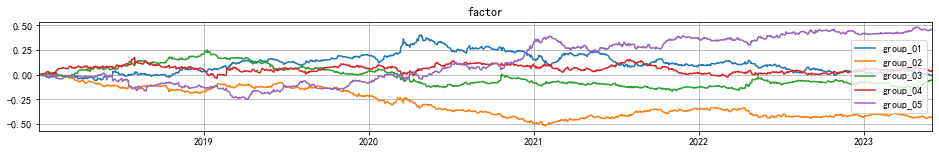

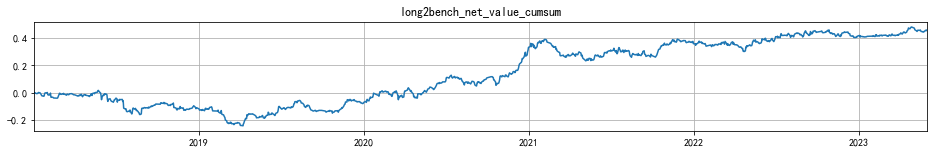

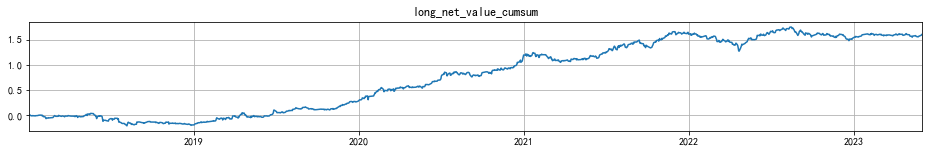

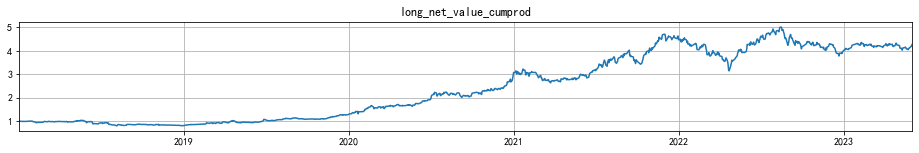

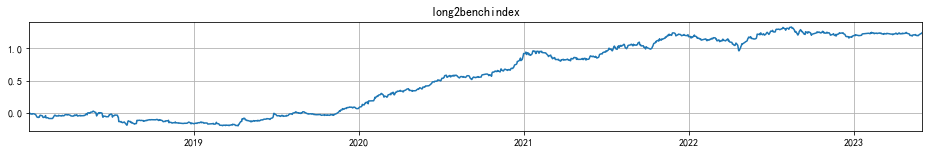

In [6]:
# 偏股型转债---BS定价因子+转债收益率因子+正股波动率因子
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=1,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_rank_class1',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_rank_class2
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.168966,-0.000093,-0.000330
group_02,0.322747,-0.000125,-0.000577
group_03,0.352003,-0.000039,-0.000532
group_04,0.307529,-0.000112,-0.000542
group_05,0.162995,0.000369,0.000141


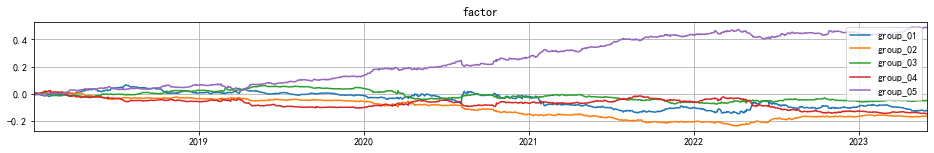

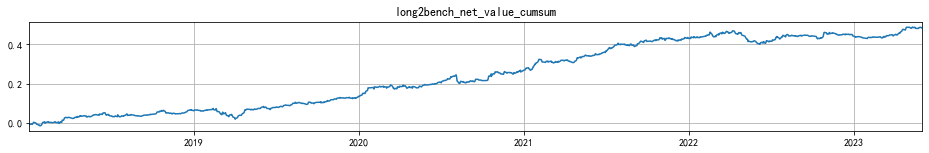

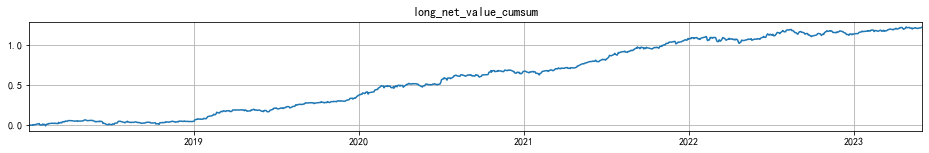

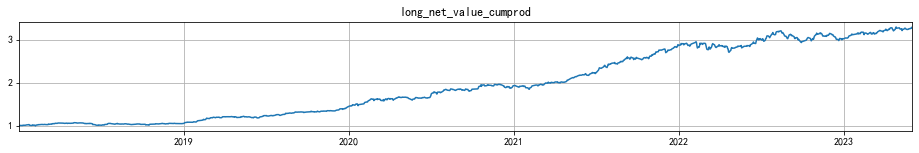

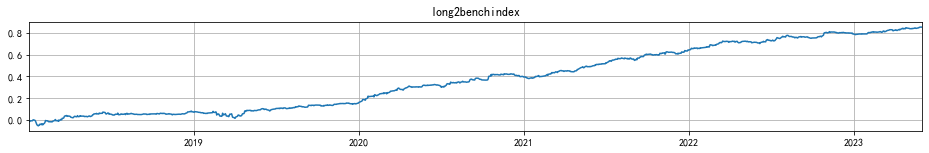

In [7]:
# 平衡型转债---BS定价因子+正股收益率因子+转债-正股振幅差因子
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=2,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_rank_class2',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_dual_low
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.155525,0.000141,-0.000077
group_02,0.194532,0.000135,-0.000137
group_03,0.171931,-0.000065,-0.000306
group_04,0.110895,-0.000079,-0.000234
group_05,0.041231,-0.000132,-0.000190


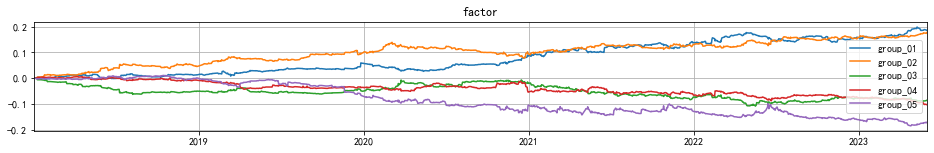

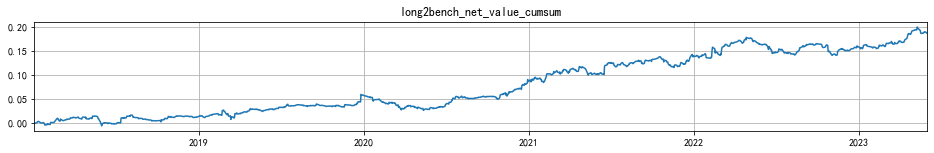

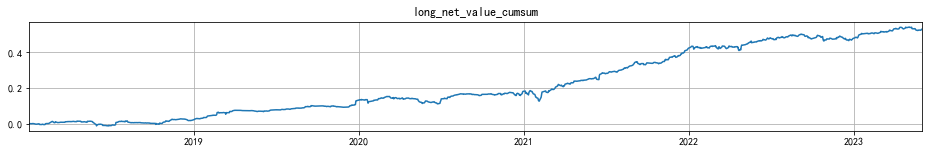

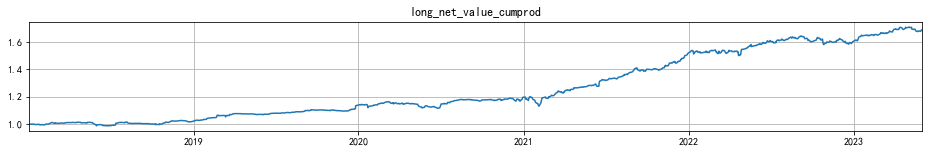

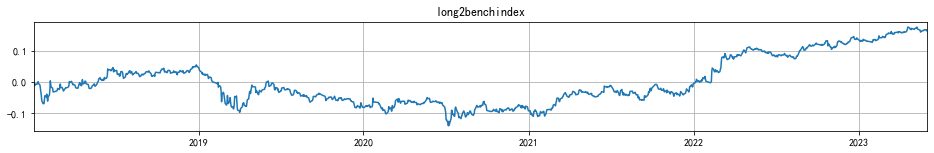

In [8]:
# 偏债型转债---双低因子
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=3,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_dual_low',nextpct='pct_close_next_close',long_low=1,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

### 东方研报23/07/01因子计算

In [6]:
# 正股动量类因子-RSI
df_ccb_positive_pct20 = pd.DataFrame(index=df_ccb_pctchg.index,columns=df_ccb_pctchg.columns)
for i in tqdm(range(20, len(df_ccb_pctchg))):
    df_ccb_positive_pct20.iloc[i,] = df_ccb_pctchg.iloc[i-19:i+1,].apply(lambda x: x[x > 0].sum(), axis=0)
factor_stock_RSI = df_ccb_positive_pct20 / df_ccb_pctchg.abs().rolling(20,min_periods=10).sum().replace(0,np.nan)
factor_stock_RSI

# 正股动量类因子-Percent B + Price To High
# 计算布林线下轨：20日的移动平均线 - 2倍标准差
df_bollinger_lower = df_ccb_close.rolling(20,min_periods=10).mean() - 2*df_ccb_close.rolling(20,min_periods=10).std()
df_bollinger_higher = df_ccb_close.rolling(20,min_periods=10).mean() + 2*df_ccb_close.rolling(20,min_periods=10).std()
factor_percentB = (df_ccb_close - df_bollinger_lower) / (df_bollinger_higher - df_bollinger_lower)

factor_price2high = df_ccb_close / df_ccb_high.rolling(20,min_periods=10).max()

# 正股量价结合因子-Amihud
factor_Amihud = (df_ccb_pctchg.abs() / df_ccb_amount).rolling(20,min_periods=10).mean()

# 转债量价因子-偏度
factor_skewness = df_ccb_pctchg.rolling(20,min_periods=10).skew()


100%|██████████████████████████████████████████████████████████████████████████████| 1797/1797 [18:43<00:00,  1.60it/s]


,128015.SZ,117128.SZ,117117.SZ,S72466.IOC,117137.SZ,117164.SZ,128108.SZ,123001.SZ,117127.SZ,117118.SZ,...,123159.SZ,113525.SH,113638.SH,113656.SH,113580.SH,113625.SH,113539.SH,113600.SH,113043.SH,113644.SH
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:


'''
23个因子

转债收益率因子 + 正股波动率因子 + BS定价偏差因子 + 正股收益率因子 + 转债-正股振幅差因子 + 双低因子 +
转股溢价率因子 + 转债收盘价 + 正股市值 + 正股预期ROE + 正股涨跌幅与大盘同步指标 +
正股beta + 隐含波动率 + 隐含波动率与正股240日波动率之差 + 债券余额 + 转债20日换手/60日换手 +
正股RSI + 正股percentB + 正股price2high + 正股Amihud + 转债收益率偏度 + 正股深度学习1 +正股深度学习2
'''

all_factors=[factor_ret60, factor_stock_std, factor_deviation_BS,factor_stock_mean40, factor_dif_amplitude, -factor_dual_low,
                  -df_ccb_convpremium_ratio, -df_ccb_close, -df_stock_mv, df_stock_roe, df_stock_corr,
                  df_stock_beta, -df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
                 -factor_stock_RSI, -factor_percentB, -factor_price2high, -factor_Amihud, factor_skewness,
                  df_stock_dl1, df_stock_dl2]

chen_factors=[-factor_dual_low,-df_ccb_close, -df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
                  -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,5*df_stock_dl1,5*df_stock_dl2]

other_factors=[factor_ret60, factor_stock_std, factor_deviation_BS,factor_stock_mean40, factor_dif_amplitude,
               -factor_stock_RSI, -factor_percentB, -factor_price2high, -factor_Amihud, factor_skewness]


### 18年至今

factor_name: factor_total_chen
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.096372,-0.000625,-0.000760
group_02,0.222549,-0.000289,-0.000601
group_03,0.265450,-0.000085,-0.000457
group_04,0.244109,0.000228,-0.000114
group_05,0.114327,0.000771,0.000611


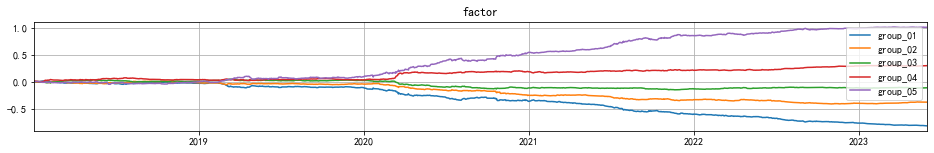

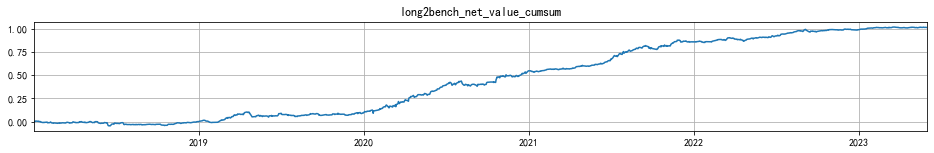

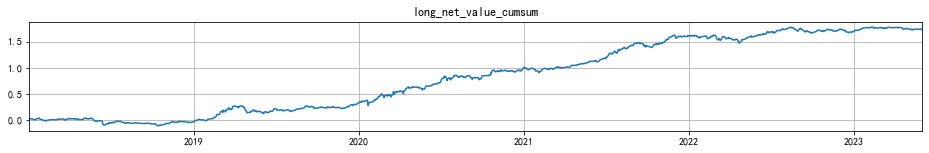

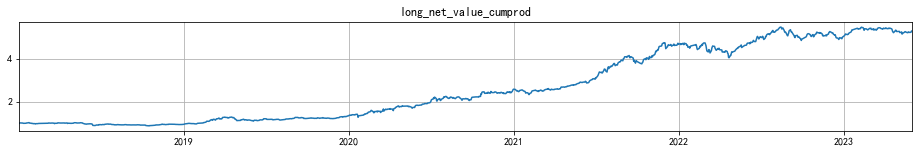

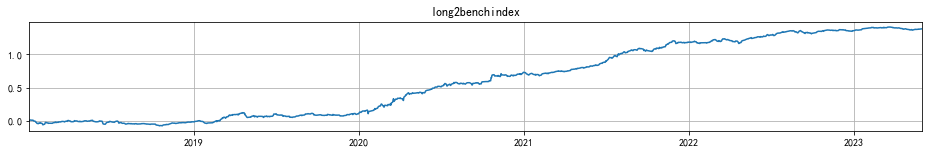

In [214]:
# chen全体可转债 
chen_factors=[-factor_dual_low,-df_ccb_close, -df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
              -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,5*df_stock_dl1,5*df_stock_dl2]

factors_rank = factor_rank(chen_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_total_chen.csv")

C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_total_chen',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df


factor_name: factor_total_try
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.087038,-0.000510,-0.000632
group_02,0.207949,-0.000408,-0.000699
group_03,0.253011,-0.000032,-0.000386
group_04,0.243124,0.000073,-0.000268
group_05,0.114210,0.000877,0.000717


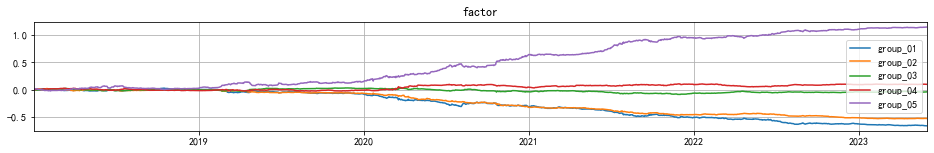

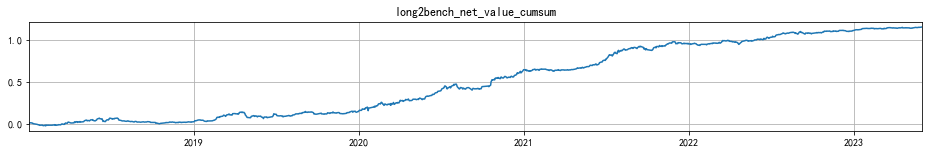

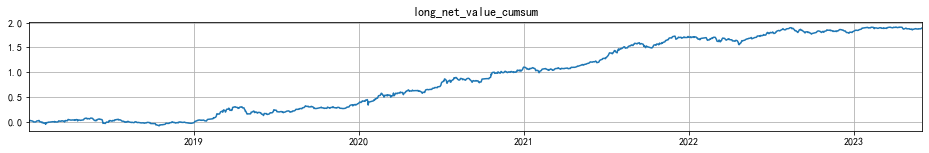

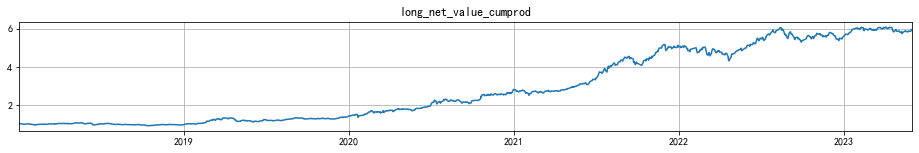

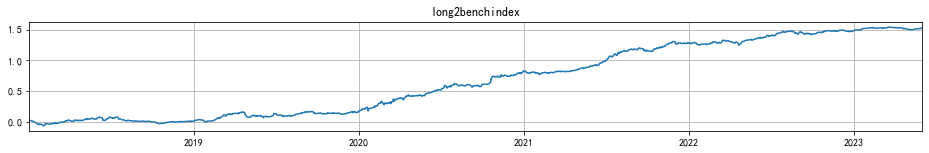

In [215]:
selected_factors=[-factor_dual_low,-df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
                  -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,df_stock_dl1,df_stock_dl2,
                 factor_stock_std, factor_deviation_BS,factor_stock_mean40, factor_dif_amplitude]

factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_total_try.csv")
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_total_try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_total_chen
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.199102,-0.001042,-0.001321
group_02,0.323537,-0.000401,-0.000854
group_03,0.357882,-0.000078,-0.000579
group_04,0.333726,0.000301,-0.000166
group_05,0.180921,0.001221,0.000967


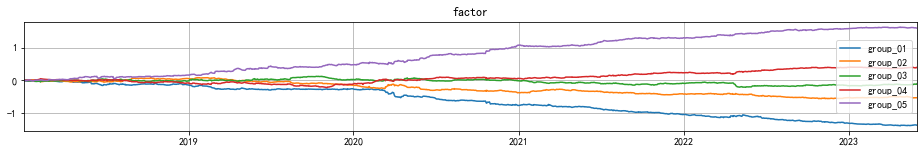

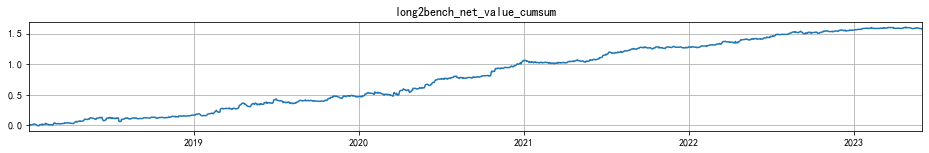

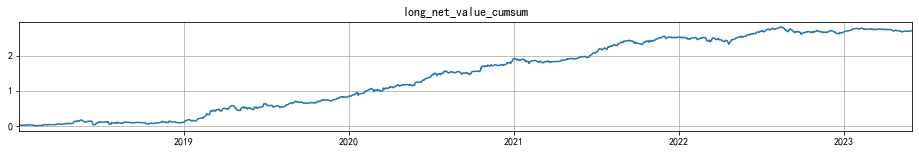

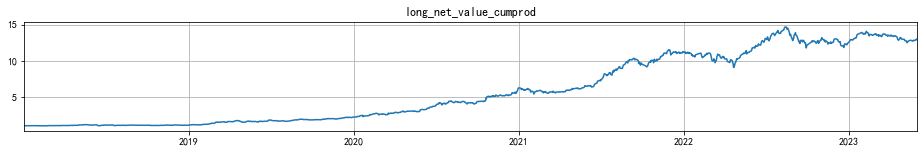

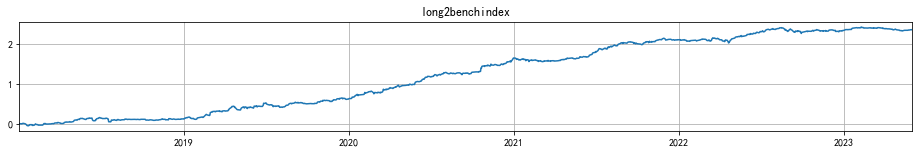

In [222]:
# chen偏股可转债 
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=1,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_total_chen',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df


factor_name: factor_Equity-like_try
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.178492,-0.000994,-0.001244
group_02,0.293777,-0.000380,-0.000791
group_03,0.328501,-0.000003,-0.000463
group_04,0.300678,0.000234,-0.000187
group_05,0.156154,0.001143,0.000924


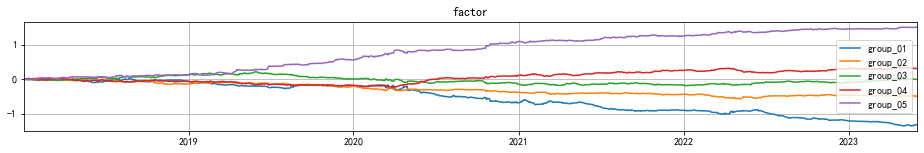

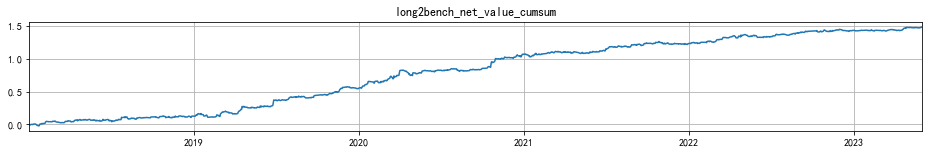

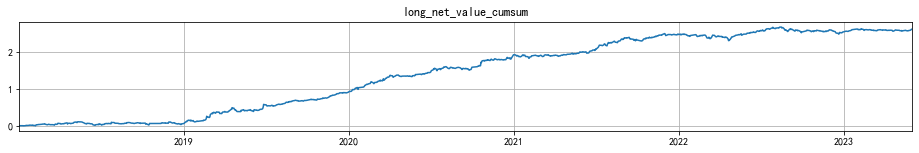

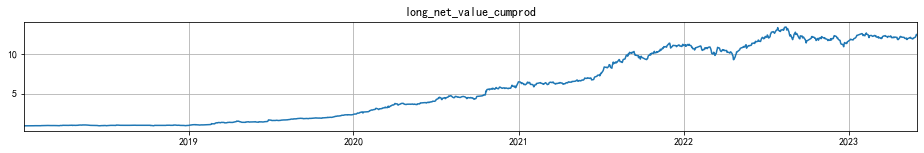

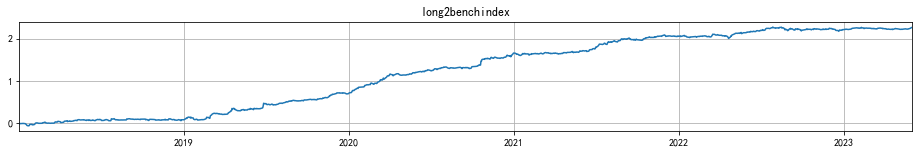

In [217]:
selected_factors=[factor_ret60,factor_stock_std,factor_deviation_BS,factor_stock_mean40,factor_dif_amplitude,-factor_dual_low,
                  -df_ccb_convpremium_ratio,-df_ccb_close,-df_stock_mv,df_stock_roe,df_stock_dl1,df_stock_dl2]

factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_Equity-like_try.csv")
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=1,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_Equity-like_try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_total_chen
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.130816,-0.000449,-0.000632
group_02,0.251759,-0.000221,-0.000574
group_03,0.288200,-0.000092,-0.000495
group_04,0.260216,0.000249,-0.000116
group_05,0.143636,0.000514,0.000312


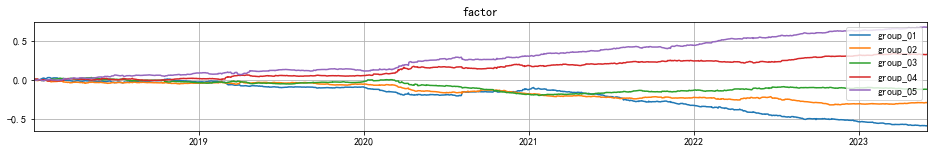

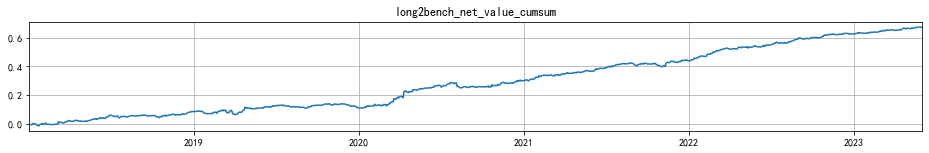

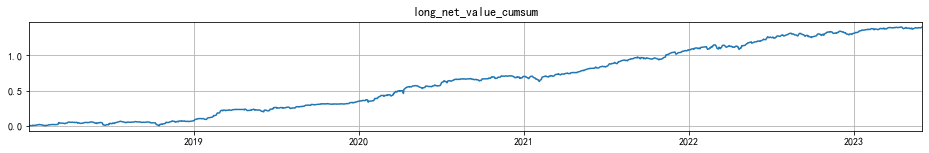

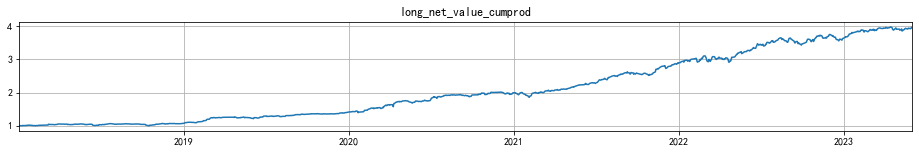

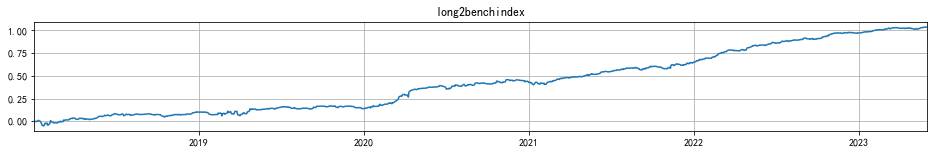

In [218]:
# chen平衡可转债 
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=2,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_total_chen',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_Balanced_try
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.128103,-0.000372,-0.000551
group_02,0.258414,-0.000258,-0.000620
group_03,0.297907,-0.000007,-0.000424
group_04,0.276090,0.000153,-0.000234
group_05,0.151181,0.000484,0.000272


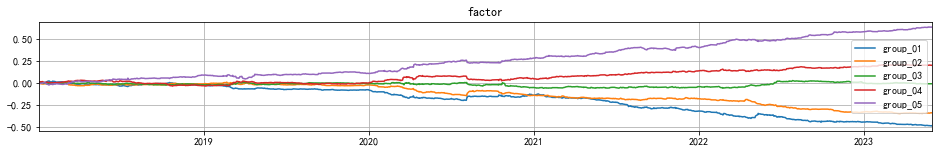

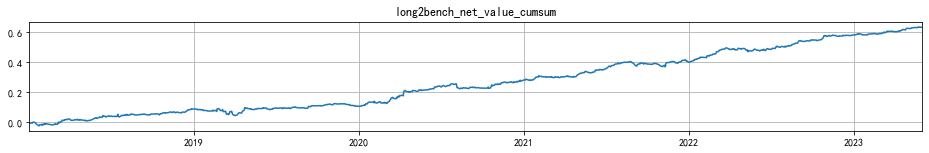

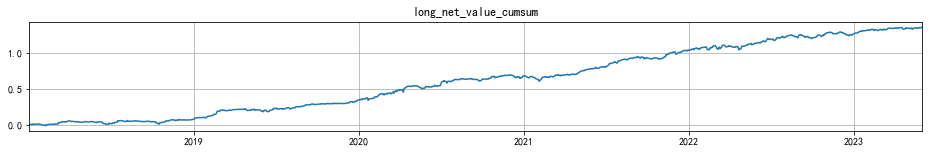

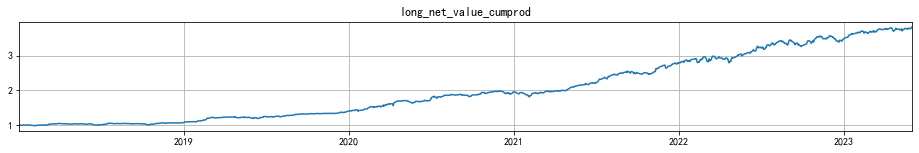

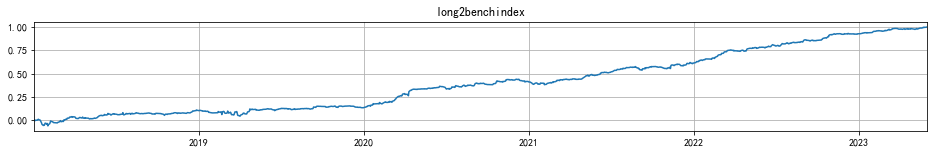

In [219]:
selected_factors=[-factor_dual_low,-df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
                  -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,df_stock_dl1,df_stock_dl2,
                  factor_stock_mean40, factor_dif_amplitude]

factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_Balanced_try.csv")

C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=2,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_Balanced_try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_total_chen
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.111461,-0.000220,-0.000376
group_02,0.233234,-0.000107,-0.000433
group_03,0.274516,0.000030,-0.000354
group_04,0.255999,0.000037,-0.000321
group_05,0.140639,0.000260,0.000063


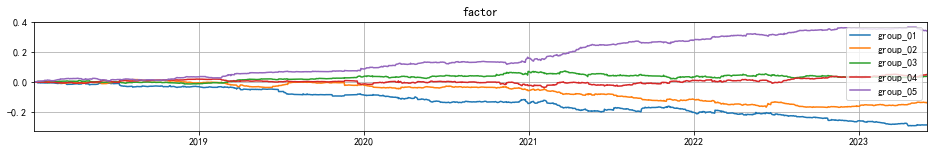

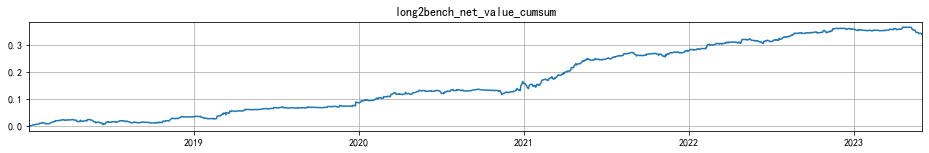

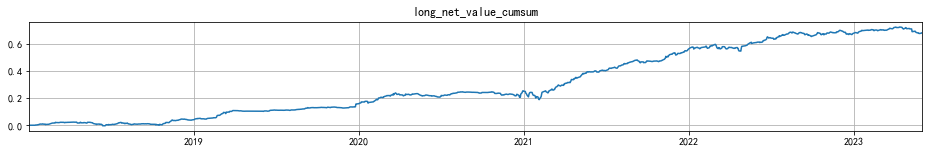

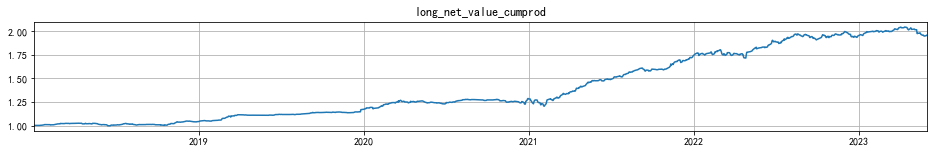

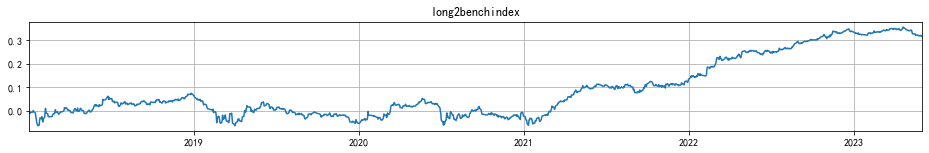

In [220]:
# chen偏债可转债 
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=3,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_total_chen',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_Debt-like_try
start_date,end_date 2018-01-01 2023-06-01
2018-01-02
2019-01-11
2020-01-21
2021-02-01
2022-02-17
2023-02-28


,turnover,gross,net
group_01,0.118386,-0.000207,-0.000372
group_02,0.250099,-0.000037,-0.000387
group_03,0.290030,-0.000037,-0.000443
group_04,0.273352,0.000063,-0.000320
group_05,0.148906,0.000218,0.000009


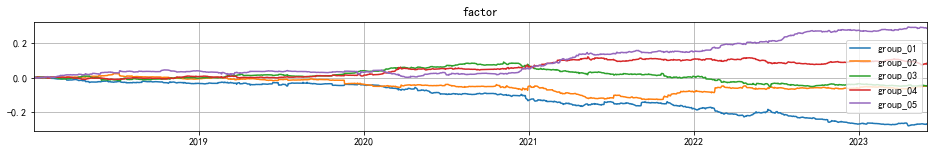

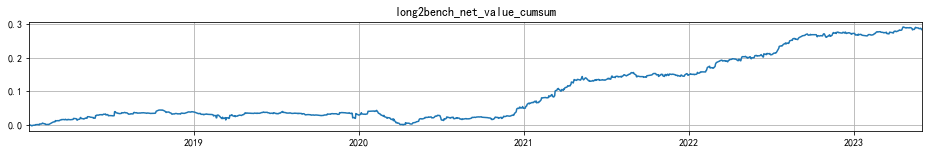

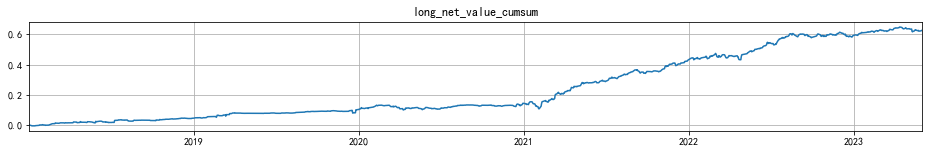

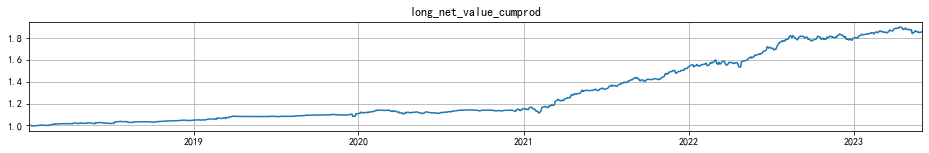

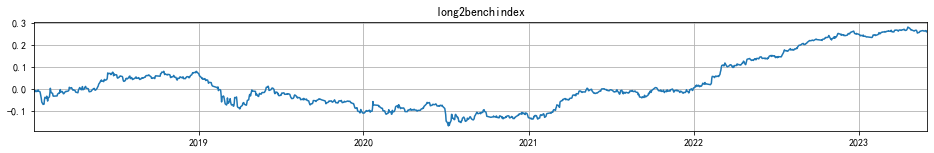

In [221]:
selected_factors=[-factor_dual_low,-df_BS_iv, -df_BS_iv_bias, -df_ccb_outstanding_balance, df_ccb_turn,
                  -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,df_stock_dl1,df_stock_dl2,
                  factor_stock_mean40, factor_dif_amplitude,factor_deviation_BS,factor_stock_mean40]

factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_Debt-like_try.csv")

C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=3,index_pool='ZZZZ',start_date='20180101',end_date='20230601',factor_name='factor_Debt-like_try',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

### 22年至今

factor_name: factor_total_ccb
start_date,end_date 2022-01-01 2023-06-01
2022-01-04
2023-01-13


,turnover,gross,net
group_01,0.115093,-0.000381,-0.000542
group_02,0.269946,-0.000354,-0.000732
group_03,0.314693,0.000088,-0.000352
group_04,0.285058,0.000125,-0.000274
group_05,0.128847,0.000521,0.000341


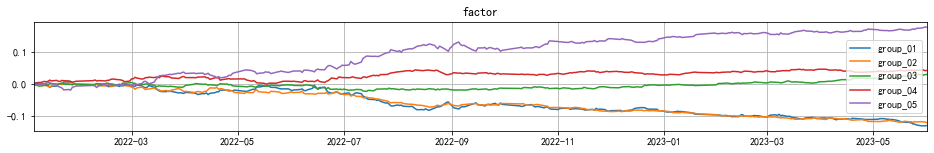

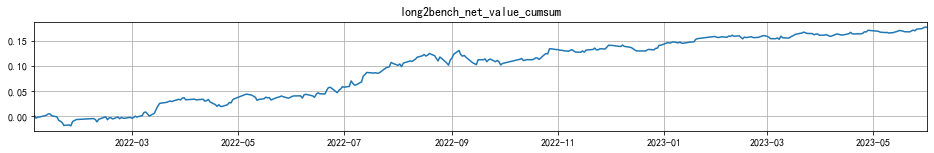

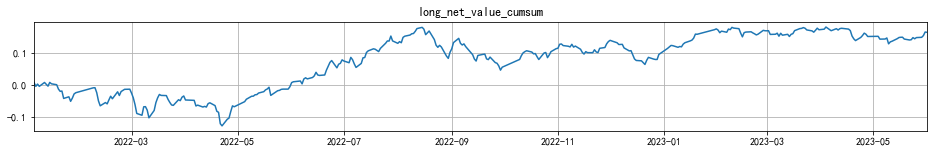

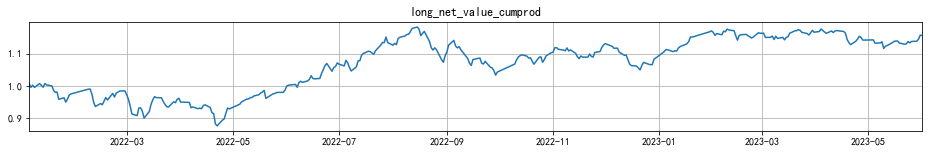

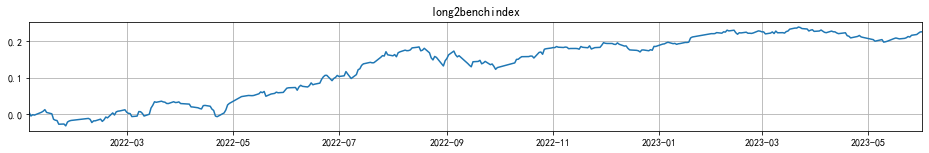

In [10]:
# 全体可转债 -- 13因子（转债收益率因子 +正股波动率因子 +BS定价偏差因子 +正股收益率因子 +转债-正股振幅差因子 +双低因子+
#                     转股溢价率因子 +正股市值 +正股预期ROE +正股涨跌幅与大盘同步指标 +正股beta +2个正股深度学习）

selected_factors=[factor_ret60,factor_stock_std,factor_deviation_BS,factor_stock_mean40,factor_dif_amplitude,-factor_dual_low,
                  -df_ccb_convpremium_ratio,-df_stock_mv,df_stock_roe,df_stock_corr,df_stock_beta,df_stock_dl1,df_stock_dl2]

factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_total_ccb.csv")
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=0,index_pool='ZZZZ',start_date='20220101',end_date='20230601',factor_name='factor_total_ccb',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df


factor_name: factor_Equity-like_ccb
start_date,end_date 2022-01-01 2023-06-20
2022-01-04
2023-01-13


,turnover,gross,net
group_01,0.149656,-0.001201,-0.001410
group_02,0.302603,-0.000118,-0.000542
group_03,0.360129,0.000512,0.000008
group_04,0.352245,0.000033,-0.000460
group_05,0.193191,0.000774,0.000504


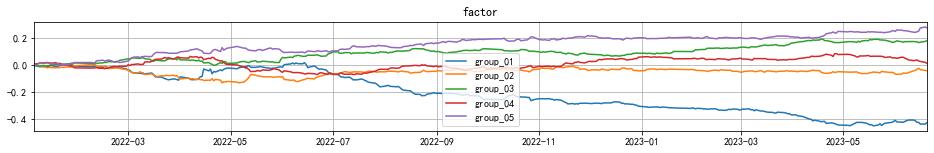

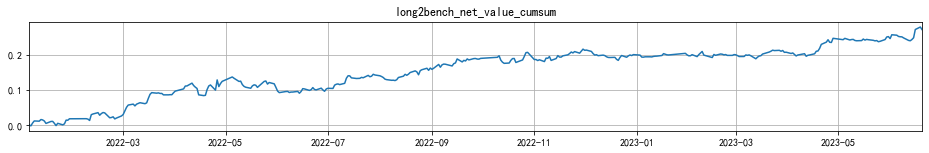

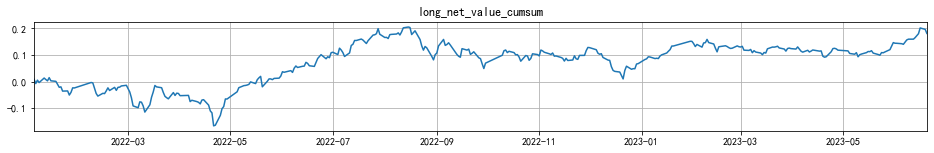

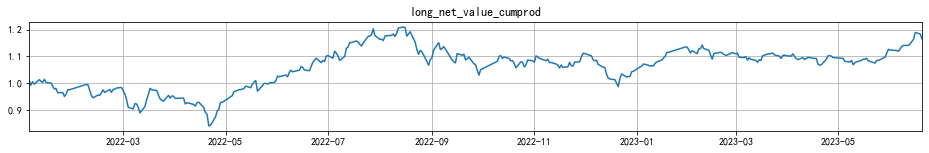

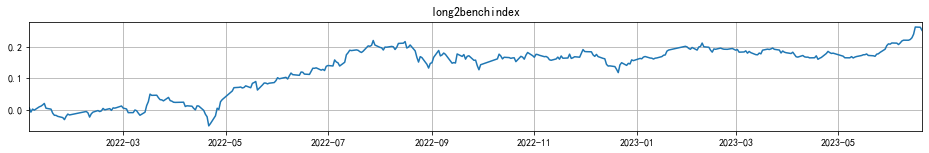

In [11]:
# 偏股型可转债 -- 12因子（转债收益率因子 +正股波动率因子 +BS定价偏差因子 +正股收益率因子 +转债-正股振幅差因子 +双低因子+
#                     转股溢价率因子 +转债收盘价 +正股市值 +正股预期ROE +2个正股深度学习）

selected_factors=[factor_ret60,factor_stock_std,factor_deviation_BS,factor_stock_mean40,factor_dif_amplitude,-factor_dual_low,
                  -df_ccb_convpremium_ratio,-df_ccb_close,-df_stock_mv,df_stock_roe,df_stock_dl1,df_stock_dl2]
factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_Equity-like_ccb.csv")
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=1,index_pool='ZZZZ',start_date='20220101',end_date='20230620',factor_name='factor_Equity-like_ccb',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_Balanced_ccb
start_date,end_date 2022-01-01 2023-06-01
2022-01-04
2023-01-13


,turnover,gross,net
group_01,0.258492,-0.000702,-0.001063
group_02,0.466145,-0.000089,-0.000741
group_03,0.503169,0.000168,-0.000537
group_04,0.448106,0.000025,-0.000602
group_05,0.228571,0.000598,0.000278


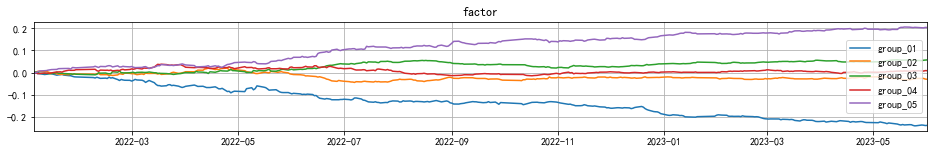

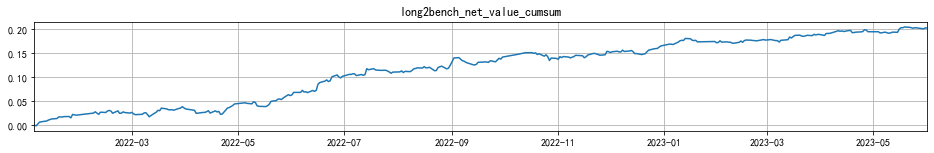

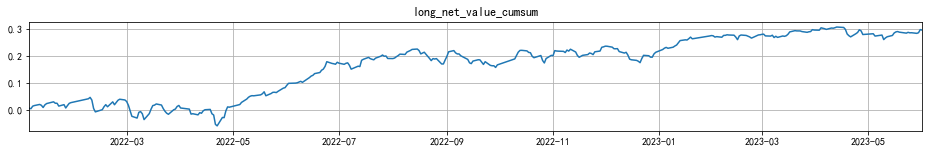

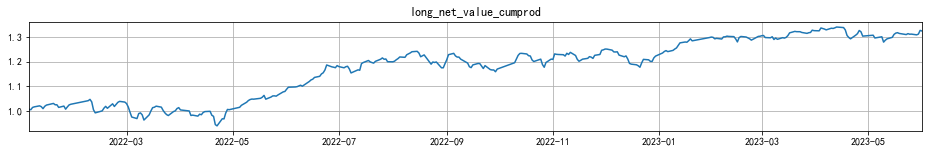

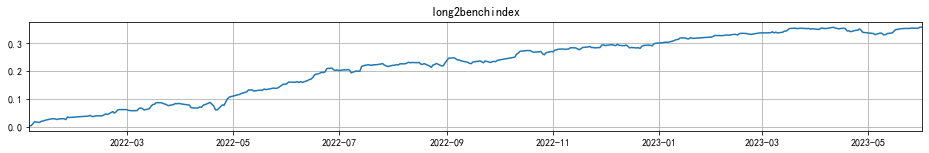

In [12]:
# 平衡型可转债 -- 12因子（双低因子 +转股溢价率因子 +隐含波动率 +隐含波动率与正股240日波动率之差 +债券余额 + 转债20日换手/60日换手+
#                     正股RSI +正股percentB +正股price2high +正股Amihud +2个正股深度学习）
selected_factors=[-factor_dual_low,-df_ccb_convpremium_ratio,-df_BS_iv,-df_BS_iv_bias,-df_ccb_outstanding_balance,df_ccb_turn,
                 -factor_stock_RSI,-factor_percentB,-factor_price2high,-factor_Amihud,df_stock_dl1,df_stock_dl2]

factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_Balanced_ccb.csv")

C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=2,index_pool='ZZZZ',start_date='20220101',end_date='20230601',factor_name='factor_Balanced_ccb',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

factor_name: factor_Debt-like_ccb
start_date,end_date 2022-01-01 2023-06-20
2022-01-04
2023-01-13


,turnover,gross,net
group_01,0.173939,-0.000162,-0.000406
group_02,0.363171,-0.000128,-0.000637
group_03,0.406638,-0.000089,-0.000658
group_04,0.361601,-0.000011,-0.000517
group_05,0.195407,0.000390,0.000116


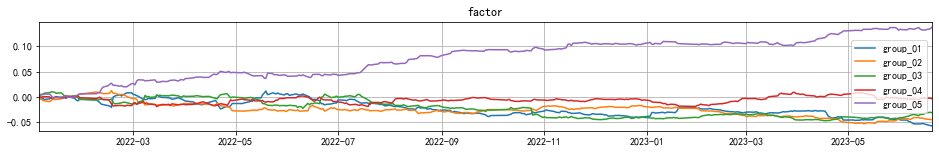

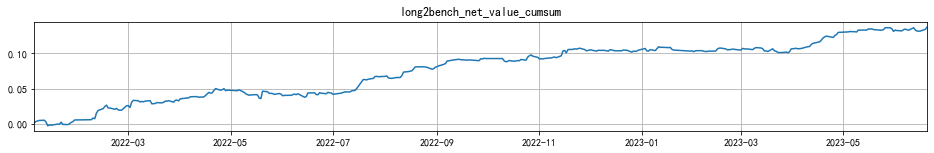

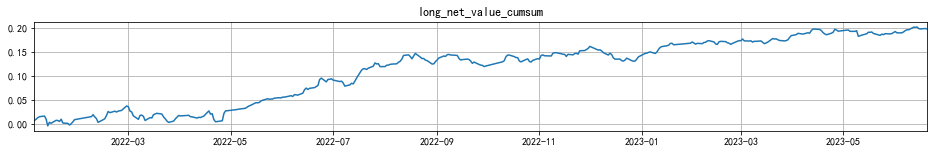

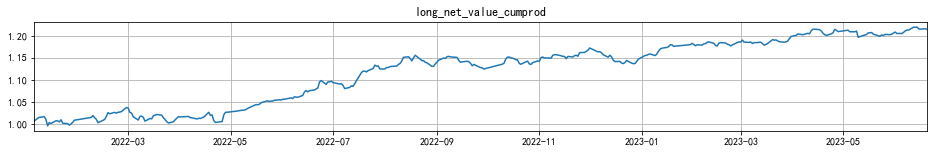

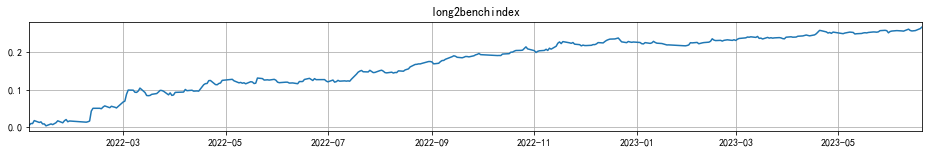

In [13]:
# 偏债型可转债 -- 7因子（双低 +2个正股深度学习+ 转债收益率因子+BS定价偏差因子+正股收益率因子+转股溢价率因子）

selected_factors=[-factor_dual_low,df_stock_dl1,df_stock_dl2,
                 factor_ret60,factor_deviation_BS,factor_stock_mean40,-df_ccb_convpremium_ratio]
factors_rank = factor_rank(selected_factors)
factors_rank.to_csv(r"C:\Users\nibh\Desktop\FZ\CCB\factor_Debt-like_ccb.csv")
C = SingleFactorAnalysis_CCB(df_ccb_class,class_n=3,index_pool='ZZZZ',start_date='20220101',end_date='20230620',factor_name='factor_Debt-like_ccb',nextpct='pct_close_next_close',long_low=0,dt_index='240m',n_group=5,neu_style=None,calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df